In [13]:
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, AveragePooling2D,
                                     GlobalAveragePooling2D, BatchNormalization,
                                     Activation, Add, Concatenate, Dense, Dropout,
                                     Multiply, Reshape)
import os, kagglehub

# Disable XLA JIT (to avoid huge pinned‐host allocs)
tf.config.optimizer.set_jit(False)

# GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(" GPU memory growth enabled")
else:
    print(" No GPU detected")

mixed_precision.set_global_policy('mixed_float16')
print(" Mixed precision policy:", mixed_precision.global_policy())


 GPU memory growth enabled
 Mixed precision policy: <DTypePolicy "mixed_float16">


In [14]:
import os
import kagglehub

# Download the PlantVillage dataset by emmarex
path = kagglehub.dataset_download("emmarex/plantdisease")
print("Raw dataset path:", path)


main_folder = "PlantVillage"  # This is the main folder name
main_path = os.path.join(path, main_folder)
print("Main folder:", main_folder)
print("Contents of main folder:", os.listdir(main_path)[:5])

image_root = main_path
print("Image root folder:", image_root)

# List the disease classes
classes = os.listdir(image_root)
print("Classes found:", classes[:10])
print("Total number of classes:", len(classes))


Raw dataset path: /kaggle/input/plantdisease
Main folder: PlantVillage
Contents of main folder: ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot']
Image root folder: /kaggle/input/plantdisease/PlantVillage
Classes found: ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot']
Total number of classes: 15


In [15]:
#Load datasets with one hot labels
import tensorflow as tf

batch_size = 8
img_size   = (160, 160)

dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    image_root,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
dataset_val = tf.keras.preprocessing.image_dataset_from_directory(
    image_root,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Train element spec:", dataset_train.element_spec)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Train element spec: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))


In [16]:
num_classes = dataset_train.element_spec[1].shape[-1]
print("Detected num_classes =", num_classes)

Detected num_classes = 15


In [17]:
#Preprocessing
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = (
    dataset_train
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(500)
    .prefetch(1)
)

val_ds = (
    dataset_val
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .prefetch(1)
)

In [18]:
import tensorflow as tf
import math
from tensorflow.keras import layers, regularizers, backend as K, Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, AveragePooling2D,
    GlobalAveragePooling2D, Dense, Dropout, Concatenate,Reshape, Dot, Add, Lambda
)

In [19]:
def rsa_attention(x, reg_l2=1e-4, reg_l1=1e-4, name=None):
    C = x.shape[-1]
    H = x.shape[1]
    W = x.shape[2]
    N = H * W

    f = Conv2D(C,1,padding='same',use_bias=True,
               kernel_regularizer=regularizers.l2(reg_l2),
               bias_regularizer   =regularizers.l1(reg_l1),
               name=(name+"_f" if name else None))(x)
    g = Conv2D(C,1,padding='same',use_bias=True,
               kernel_regularizer=regularizers.l2(reg_l2),
               bias_regularizer   =regularizers.l1(reg_l1),
               name=(name+"_g" if name else None))(x)
    h = Conv2D(C,1,padding='same',use_bias=True,
               kernel_regularizer=regularizers.l2(reg_l2),
               bias_regularizer   =regularizers.l1(reg_l1),
               name=(name+"_h" if name else None))(x)

    f_flat = Reshape((N, C), name=(name+"_reshape_f" if name else None))(f)
    g_flat = Reshape((N, C), name=(name+"_reshape_g" if name else None))(g)
    h_flat = Reshape((N, C), name=(name+"_reshape_h" if name else None))(h)

    scores = Dot(axes=(2,2), name=(name+"_score" if name else None))([f_flat, g_flat])

    inv_sqrt_C = 1.0 / math.sqrt(C)
    scores = Lambda(lambda t: t * inv_sqrt_C,
                    name=(name+"_scale" if name else "rsa_scale"))(scores)

    alpha = Activation('softmax', name=(name+"_softmax" if name else "rsa_softmax"))(scores)
    o_flat = Dot(axes=(2,1), name=(name+"_apply" if name else "rsa_apply"))([alpha, h_flat])
    o = Reshape((H, W, C), name=(name+"_out" if name else "rsa_out"))(o_flat)
    return o

In [20]:
#Model building blocks

def residual_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters,3,strides=stride,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x); x=Activation('relu')(x)
    x = Conv2D(filters,3,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    if stride!=1 or shortcut.shape[-1]!=filters:
        shortcut = Conv2D(filters,1,strides=stride,use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x,shortcut]); return Activation('relu')(x)

def residual_block_group(x, f, n, stride=1):
    x = residual_block(x,f,stride)
    for _ in range(1,n):
        x = residual_block(x,f,1)
    return x

def dense_block(x, layers_n, g_rate):
    feats = [x]
    for _ in range(layers_n):
        y = Concatenate()(feats)
        y = BatchNormalization()(y); y=Activation('relu')(y)
        y = Conv2D(4*g_rate,1,padding='same',use_bias=False)(y)
        y = BatchNormalization()(y); y=Activation('relu')(y)
        y = Conv2D(g_rate,3,padding='same',use_bias=False)(y)
        feats.append(y)
    return Concatenate()(feats)

def transition_layer(x):
    x = BatchNormalization()(x)
    x = Conv2D(x.shape[-1]//2,1,padding='same',use_bias=False)(x)
    return AveragePooling2D(2,2)(x)


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks, optimizers, losses
import os
from google.colab import drive



def build_rsa_derefnet(input_shape=(160,160,3), num_classes=15, growth_rate=12):
    i = Input(shape=input_shape)

    # Initial conv
    x0 = Conv2D(32,3,padding='same',use_bias=False)(i)
    x0 = BatchNormalization()(x0); x0 = Activation('relu')(x0)

    # Residual stream with RSA
    r1 = residual_block_group(x0,  64, 1, stride=1)
    p1 = AveragePooling2D(pool_size=4)(r1)
    a1 = rsa_attention(p1, name="res1")
    r2 = residual_block_group(a1, 128, 1, stride=2)
    p2 = AveragePooling2D(pool_size=2)(r2)
    a2 = rsa_attention(p2, name="res2")
    r3 = residual_block_group(a2, 256, 1, stride=2)
    g_r = GlobalAveragePooling2D()(r3)

    # Dense stream with RSA
    d1 = Conv2D(32,3,padding='same',use_bias=False)(i)
    d1 = BatchNormalization()(d1); d1 = Activation('relu')(d1)
    d1 = MaxPooling2D(2)(d1)
    db1 = dense_block(d1, 3, growth_rate)
    t1 = transition_layer(db1)
    a3 = rsa_attention(t1, name="dens1")
    db2 = dense_block(a3, 3, growth_rate)
    t2 = transition_layer(db2)
    a4 = rsa_attention(t2, name="dens2")
    db3 = dense_block(a4, 5, growth_rate)
    g_d = GlobalAveragePooling2D()(db3)

    # Fuse & classify
    f = Concatenate()([g_r, g_d])
    f = Dropout(0.5)(f)
    out = Dense(num_classes, activation='softmax', dtype='float32')(f)

    return Model(i, out)

# Learning rate schedule
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Build and compile the model
model = build_rsa_derefnet(
    input_shape=(160,160,3),
    num_classes=num_classes,
    growth_rate=12
)
from tensorflow.keras import optimizers, losses

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
total_steps = steps_per_epoch * 30

cosine = optimizers.schedules.CosineDecay(
    initial_learning_rate=3e-4, decay_steps=total_steps
)

opt = optimizers.AdamW(learning_rate=cosine, weight_decay=1e-4, clipnorm=1.0)

model.compile(
    optimizer=opt,
    loss=losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


print(model.summary())




Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 160, 160,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        128 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 80, 80,    │          0 │ activation_37[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 80, 80,    │          0 │ max_pooling2d_1[… │
│ (Concatenate)       │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ concatenate_15[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 80, 80,    │      1,536 │ activation_38[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        192 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 80, 80,    │      5,184 │ activation_39[0]… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 80, 80,    │          0 │ max_pooling2d_1[… │
│ (Concatenate)       │ 44)               │            │ conv2d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        176 │ concatenate_16[0… │
│ (BatchNormalizatio… │ 44)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 44)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 80, 80,    │      2,112 │ activation_40[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        192 │ conv2d_48[0][0] 

 Total params: 1,380,060 (5.26 MB)

 Trainable params: 1,374,782 (5.24 MB)

 Non-trainable params: 5,278 (20.62 KB)

None


In [26]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)


Epoch 1/2
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 152s 71ms/step - accuracy: 0.6955 - loss: 1.4438 - val_accuracy: 0.5781 - val_loss: 1.9013
Epoch 2/2
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.8070 - loss: 1.1730 - val_accuracy: 0.8406 - val_loss: 1.0837


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_183']]
Received: inputs=Tensor(shape=(1, 160, 160, 3))
  warnings.warn(msg)


Heatmap shape: (20, 20)
Heatmap values (first 10x10): [[ 0.       0.02174  0.087    0.087    0.087    0.087    0.087    0.087
   0.087    0.087  ]
 [ 0.       0.       0.0435   0.02174  0.0435   0.0435   0.0435   0.087
   0.1087   0.     ]
 [ 0.       0.0435   0.1087   0.1087   0.1087   0.1305   0.1522  -0.
   0.087    0.1087 ]
 [ 0.       0.06525  0.087    0.1305   0.1305   0.0435   0.1087   0.087
   0.      -0.     ]
 [ 0.       0.0435   0.1087   0.1305   0.174    0.174    0.       0.
   0.       0.     ]
 [ 0.       0.02174  0.1305   0.1522   0.1305   0.       0.       0.
   0.       0.     ]
 [-0.       0.0435   0.087    0.1305   0.       0.       0.       0.
   0.3696   0.     ]
 [ 0.       0.       0.06525  0.174    0.06525  0.       0.       0.
   0.       0.     ]
 [ 0.       0.       0.1305   0.1957   0.0435   0.       0.       0.
   0.       0.     ]
 [ 0.       0.       0.3696   0.3696   0.06525  0.       0.       0.
   0.       0.     ]]


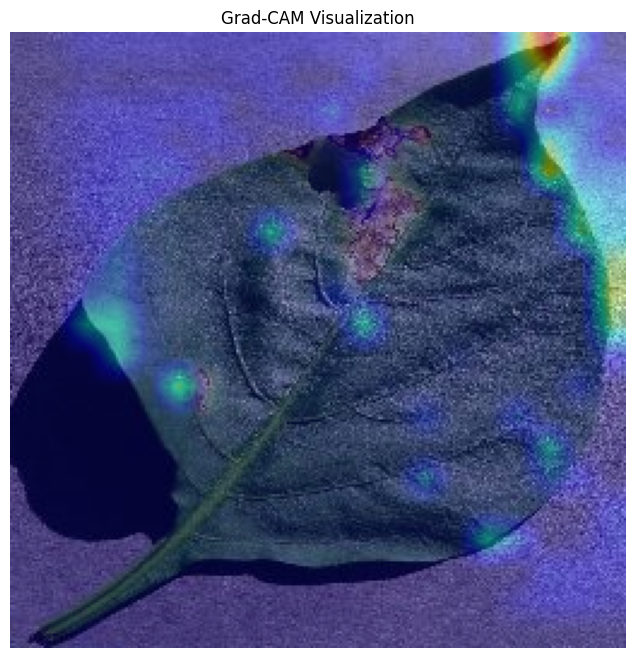

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os

# --------- CONFIGURE THIS ---------
last_conv_layer_name = "conv2d_63"  # Change to your model's last conv layer
# Update img_path to point to a file within the downloaded dataset
img_path = "/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG"  # Replace with your test image path
# Check if the path exists and get a sample image if not
if not os.path.exists(img_path):
    print(f"Image path not found: {img_path}")
    # Fallback to a known image path from the dataset if the specified one doesn't exist
    sample_class_dir = os.path.join(image_root, classes[0])
    if os.path.isdir(sample_class_dir):
        sample_image_name = os.listdir(sample_class_dir)[0]
        img_path = os.path.join(sample_class_dir, sample_image_name)
        print(f"Using sample image: {img_path}")
    else:
        raise FileNotFoundError("Could not find a valid image path.")


target_size = (160, 160)  # Change to your model's input size
# -----------------------------------

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

# Preprocess your image
img = tf.keras.preprocessing.image.load_img(img_path) # Load the image without resizing
original_img_size = img.size # Get the original size

img_resized = tf.keras.preprocessing.image.img_to_array(img.resize(target_size)) # Resize for model input
img_array = np.expand_dims(img_resized, axis=0) / 255.0  # adjust if your model uses different preprocessing


# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer_name)

print("Heatmap shape:", heatmap.shape)
print("Heatmap values (first 10x10):", heatmap[:10, :10])


# Resize heatmap to original image size using TensorFlow
heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], (original_img_size[1], original_img_size[0]))
heatmap_resized = tf.squeeze(heatmap_resized).numpy()

heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Superimpose heatmap on the original image
superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, heatmap_colored, 0.4, 0)

# Display result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()

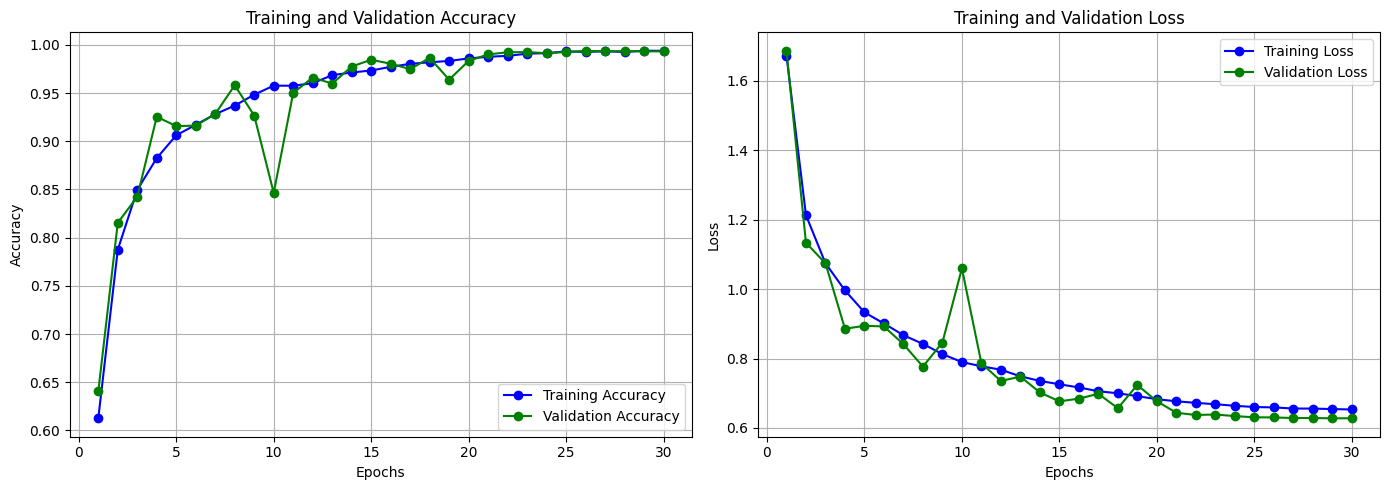

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)
